# Lab 1 - Sensor Modeling - Report

| Authors |
|---------|
| Austin Milne |
| Jude Bennett |
| William Ancich |

## Introduction
The purpose of this lab is to experiment with modeling sensor measurements to better understand the relationship between the sensor's true value and the measured value. Every sensor is suseptable to noise and errors, but various methods can be used to minimize the innaccuracy of the sensor. In this lab, we will be using sets of measured data from a 3 different infrared distance sensors to model their behaviour and performance.

## Experimental Setup
### Methodology
In order to minimize the input variables in our measurements, the experimental setup was kept as consistant as possible through the various measurements. The sensors where mounted to a stationary 90 degree bracket at a height of about 2 inches. The distance to the object was measured from the front edge of the sensor housing. The sensors were connected to the microcontroller and measurements where taken using the provided MatLab script. All measurements, except for those in Part 1C were taken at 20hz over a period of 5 seconds.

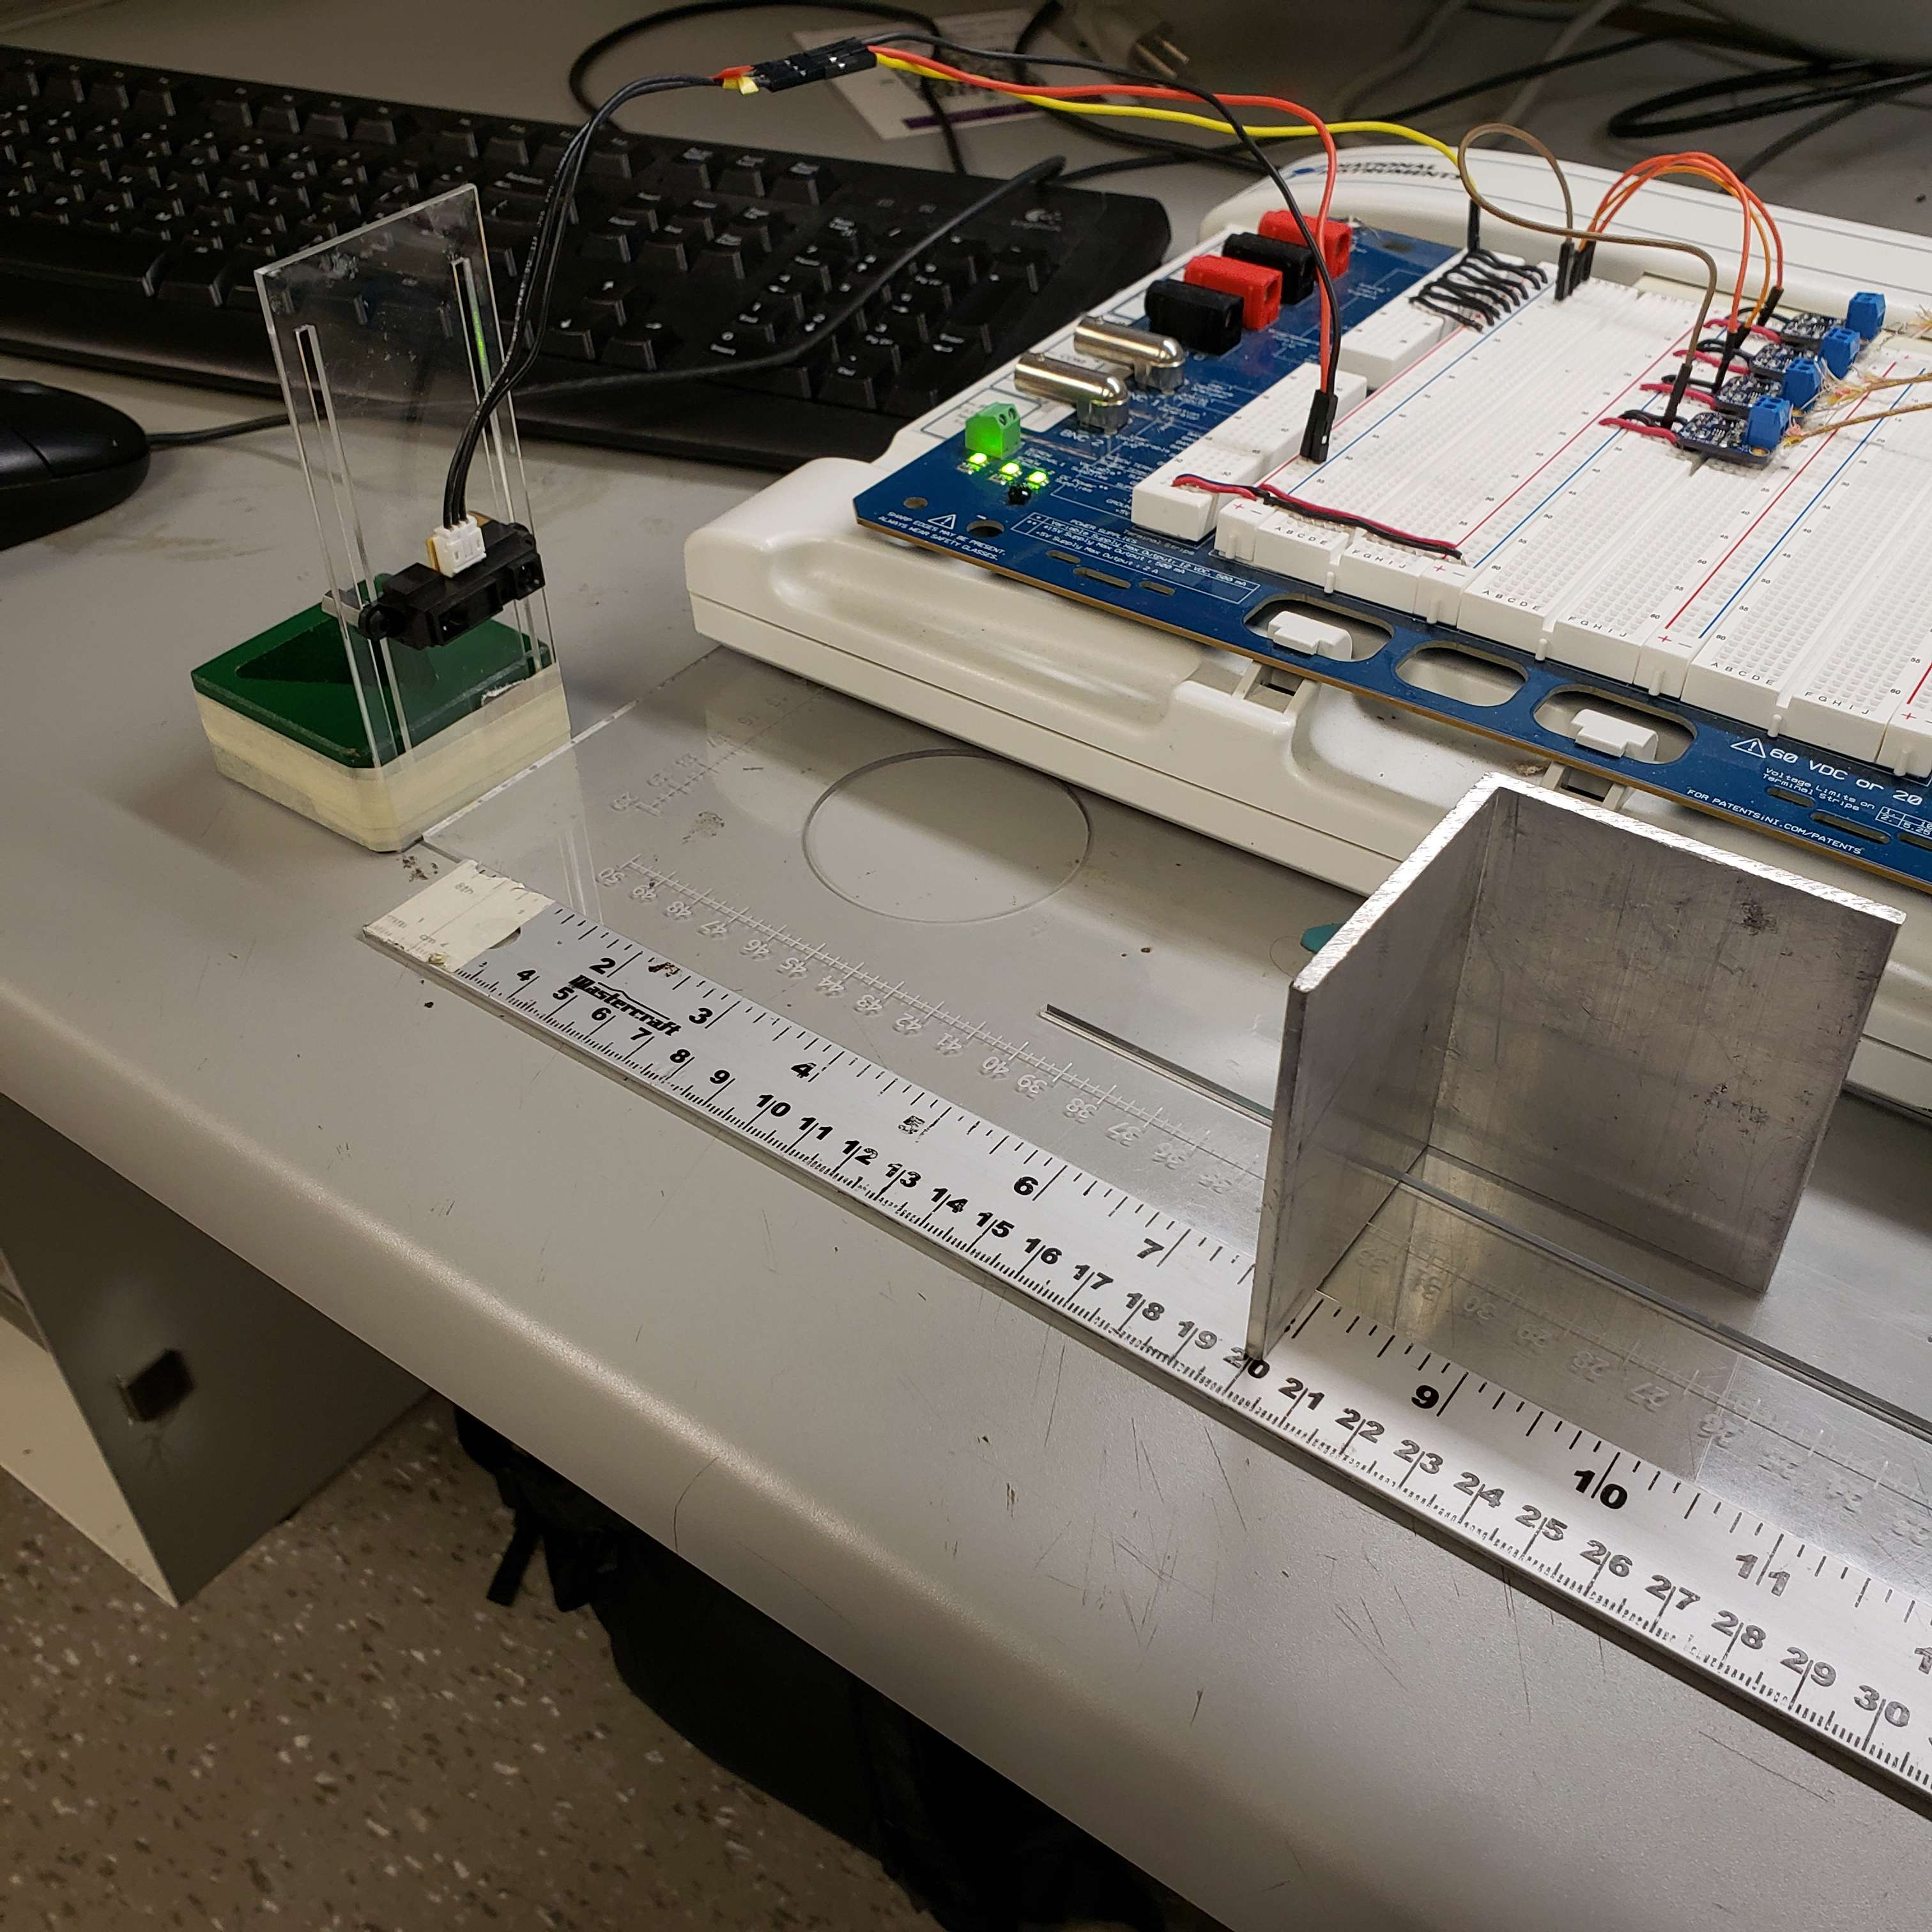

### Hardware

The sensors used in this lab are the Sharp GP2Y0A41SK0F, Sharp GP2Y0A21YK, and Sharp GP2Y0A02YK0F. These sensors are infrared distance sensors that output an analog voltage as a function of the distance of the object in front of the sensor. The sensors have a range of 4cm - 30cm, 10cm - 80cm, and 20cm - 150cm respectively. When measuring using multiple sensors, the usable range was restricted to the union of the relevant sensors' ranges.

| Sensor | Use Case | Range |
|--------|----------|-------|
| Sharp GP2Y0A41SK0F | Short Range | 4cm - 30cm |
| Sharp GP2Y0A21YK   | Medium Range | 10cm - 80cm |
| Sharp GP2Y0A02YK0F | Long Range | 20cm - 150cm |

# Part 1 - Sensor Modeling
## Part 1A - Sensor Characteristics
Before using a sensor for measuring an environment, it is important to know how the sensor behaves to various inputs. For the sensors used in these experiments, this means knowing how the output voltage of the sensor changes with distance. The method used to model these sensors was to take 11 different measurements evenly spread over their rated operating range. At each of the 11 measurement points, voltage readings were taken at 20hz for 5 seconds, resulting in roughly 100 individual data points. Taking the average of these 100 measurements for each of the 11 points, the noise of the sensor can be effectively removed, allowing for a more accurate model of the sensor's output voltage curve.

Refer to the below code for the plotting of the sensor measurements.

In [1]:
# Necessary Libraries
import json
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
import pathlib
import statistics

# Read Raw Data
with open(r"data/data.json") as f:
    data = json.load(f)

C:\Users\austi\AppData\Local\Temp\ipykernel_32444\644632444.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Part A

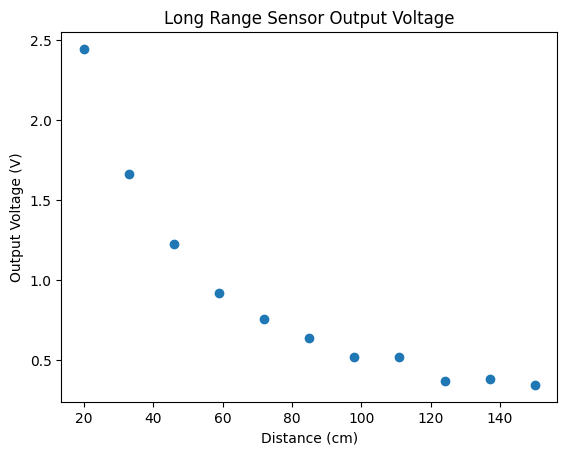

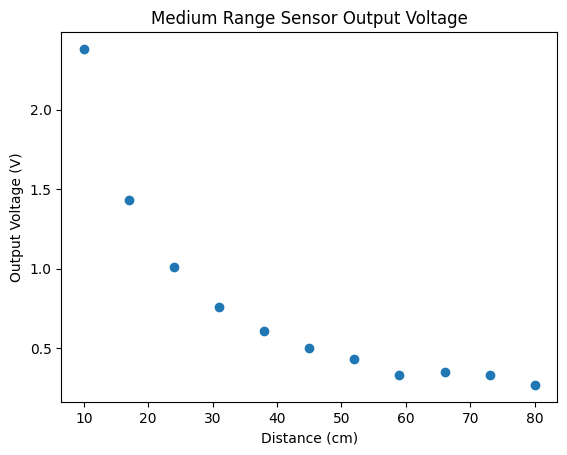

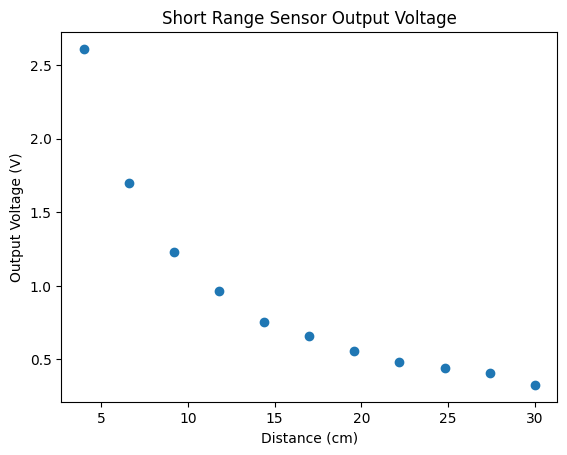

In [2]:
# Grab Part A data from the dictionary, make relevant copies
pa = data["PartA"]
a_samples = copy.deepcopy(pa) # Dictionary containing DataFrame of sample data
a_mov = copy.deepcopy(pa) # Dictionary containing mean output voltage
for sensor in pa:
    for distance in pa[sensor]:
        # Crete a DataFrame for each distance
        readings = (pa[sensor][distance]["data"])
        a_samples[sensor][distance] = readings # Store the DataFrame
        a_mov[sensor][distance] = sum(readings) / len(readings) # Store the mean output voltage
    
    # Create a plot of the sensor data
    plt.figure()
    distances = [float(dist.replace("cm", "")) for dist in a_mov[sensor].keys()]
    vals = [a_mov[sensor][dist] for dist in a_mov[sensor]]
    plt.scatter(distances, vals)
    plt.title(f"{sensor} Sensor Output Voltage")
    plt.xlabel("Distance (cm)")
    plt.ylabel("Output Voltage (V)")
    pathlib.Path("out/plots").mkdir(parents=True, exist_ok=True)
    plt.savefig(f"out/plots/{sensor}_output_voltage.png")
    plt.show()

Based on the graphs produced, it is clear that there is not a linear relationship. In order to determine what relationship is best, a set of relationships will be tested using the method of least squares. The relationships to be tested are as follows:
- Linear: $Y = mX + b$
- Inverse: $Y = \frac{a}{X} + b$
- Quadratic: $Y = aX^2 + bX + c$
- Cubic: $Y = aX^3 + bX^2 + cX + d$

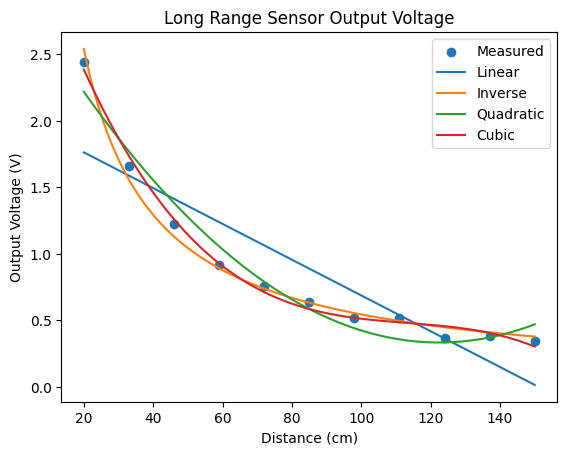

Long Range Sensor Regression Results
    Model      R^2                                                           Parameters
   Linear 0.779524                                        y = -0.013446341x + 2.0327393
  Inverse 0.990689                                        y = 49.890422/x + 0.046704563
Quadratic 0.962885                     y = 0.00017961901x^2 + -0.043981572x + 3.0269305
    Cubic 0.993821 y = -2.1150569e-06x^3 + 0.00071895852x^2 + -0.083462917x + 3.7850261


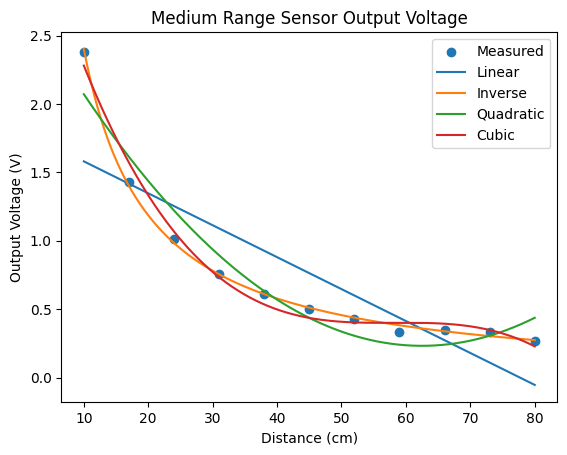

Medium Range Sensor Regression Results
    Model      R^2                                                         Parameters
   Linear 0.713501                                      y = -0.023356161x + 1.8142396
  Inverse 0.998574                                     y = 24.334172/x + -0.030560244
Quadratic 0.936592                   y = 0.00066803606x^2 + -0.083479406x + 2.8396749
    Cubic 0.987190 y = -1.6938009e-05x^3 + 0.0029546673x^2 + -0.17160448x + 3.7183511


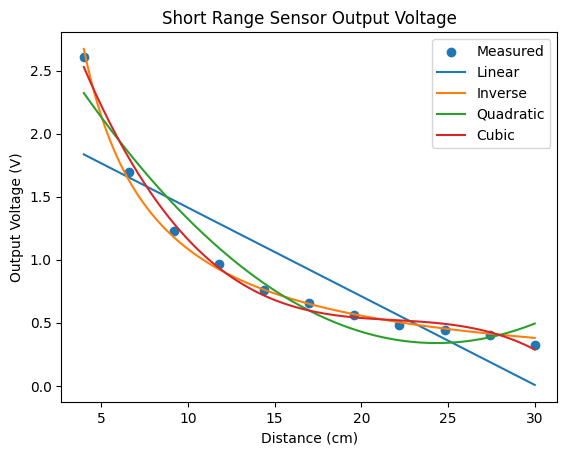

Short Range Sensor Regression Results
    Model      R^2                                                        Parameters
   Linear 0.763250                                     y = -0.070352617x + 2.1174605
  Inverse 0.996525                                      y = 10.583031/x + 0.02725546
Quadratic 0.950841                    y = 0.0048032151x^2 + -0.23366193x + 3.1808924
    Cubic 0.992947 y = -0.00032618015x^3 + 0.021438403x^2 + -0.47721151x + 4.1161891


In [3]:
# Run regression on range of functions for each sensor
for sensor in pa:
    distances = [float(dist.replace("cm", "")) for dist in a_mov[sensor].keys()]
    vals = [a_mov[sensor][dist] for dist in a_mov[sensor]]
    
    # Linear Regression
    linear = lambda x, m, b : m*x + b # Lambda for linear regression
    lin_m, lin_b = curve_fit(linear, distances, vals)[0] # Fit the data to the linear model
    lin_r2 = r2_score(vals, linear(np.asarray(distances), lin_m, lin_b)) # Get the R^2 value
    pa[sensor]["linear"] = [lin_m, lin_b, lin_r2] # Store the linear regression results
    
    # Inverse Regression
    inverse = lambda x, a, b : a/x + b # Lambda for inverse regression
    inv_a, inv_b = curve_fit(inverse, distances, vals)[0] # Fit the data to the inverse model
    inv_r2 = r2_score(vals, inverse(np.asarray(distances), inv_a, inv_b)) # Get the R^2 value
    pa[sensor]["inverse"] = [inv_a, inv_b, inv_r2] # Store the inverse regression results
    
    # Quadratic Regression
    quadratic = lambda x, a, b, c : a*x**2 + b*x + c # Lambda for quadratic regression
    quad_a, quad_b, quad_c = curve_fit(quadratic, distances, vals)[0] # Fit the data to the quadratic model
    quad_r2 = r2_score(vals, quadratic(np.asarray(distances), quad_a, quad_b, quad_c)) # Get the R^2 value
    pa[sensor]["quadratic"] = [quad_a, quad_b, quad_c, quad_r2] # Store the quadratic regression results
    
    # Cubic Regression
    cubic = lambda x, a, b, c, d : a*x**3 + b*x**2 + c*x + d # Lambda for cubic regression
    cub_a, cub_b, cub_c, cub_d = curve_fit(cubic, distances, vals)[0] # Fit the data to the cubic model
    cub_r2 = r2_score(vals, cubic(np.asarray(distances), cub_a, cub_b, cub_c, cub_d)) # Get the R^2 value
    pa[sensor]["cubic"] = [cub_a, cub_b, cub_c, cub_d, cub_r2] # Store the cubic regression results
    
    # Create a plot of the sensor data and regressions lines
    pts = np.linspace(min(distances), max(distances), 1000)
    plt.figure()
    plt.scatter(distances, vals, label="Measured")
    plt.plot(pts, linear(np.asarray(pts), lin_m, lin_b), label=f"Linear")
    plt.plot(pts, inverse(np.asarray(pts), inv_a, inv_b), label=f"Inverse")
    plt.plot(pts, quadratic(np.asarray(pts), quad_a, quad_b, quad_c), label=f"Quadratic")
    plt.plot(pts, cubic(np.asarray(pts), cub_a, cub_b, cub_c, cub_d), label=f"Cubic")
    plt.title(f"{sensor} Sensor Output Voltage")
    plt.xlabel("Distance (cm)")
    plt.ylabel("Output Voltage (V)")
    plt.legend()
    pathlib.Path("out/plots").mkdir(parents=True, exist_ok=True)
    plt.savefig(f"out/plots/{sensor}_output_voltage.png")
    plt.show()
    
    # Create a table of the regression results
    results = pd.DataFrame({
        "Model": ["Linear", "Inverse", "Quadratic", "Cubic"],
        "R^2": [lin_r2, inv_r2, quad_r2, cub_r2],
        "Parameters": [
            f"y = {lin_m:3.8}x + {lin_b:3.8}",
            f"y = {inv_a:3.8}/x + {inv_b:3.8}",
            f"y = {quad_a:3.8}x^2 + {quad_b:3.8}x + {quad_c:3.8}",
            f"y = {cub_a:3.8}x^3 + {cub_b:3.8}x^2 + {cub_c:3.8}x + {cub_d:3.8}"
        ]
    })
    pd.set_option('display.width', 1000)
    print(f"{sensor} Sensor Regression Results")
    print(results.to_string(index=False))

From both visual inspection of the graphs and comparing the $R^2$ values from the least squares method, it is clear that the inverse relationship is the best fit for all three of the sensors. This result is expected based on the graphs and relationships noted in each of the sensor's datasheets.

For the following parts of the lab, the below functions will be used to model the sensors:

$$
\begin{align*}
\text{Long Range Sensor: } & Voltage = \frac{49.890422}{Distance [cm]} + 0.046704563 \\
\text{Medium Range Sensor: } & Voltage = \frac{24.334172}{Distance [cm]} - 0.030560244 \\
\text{Short Range Sensor: } & Voltage = \frac{10.583031}{Distance [cm]} + 0.02725546 \\
\end{align*}
$$

In [5]:
# Get the maximum and minimum error values against the inverse regression
table = pd.DataFrame(columns=["Sensor", "Max Error", "Avg Error", "Min Error"])
for sensor in pa:
    distances = [float(dist.replace("cm", "")) for dist in a_mov[sensor].keys()]
    vals = [a_mov[sensor][dist] for dist in a_mov[sensor]]
    inv = lambda x : pa[sensor]['inverse'][0]/x + pa[sensor]['inverse'][1] # Lambda for inverse regression
    errors = [abs(vals[i] - inv(distances[i])) for i in range(len(distances))]
    table.loc[len(table)] = [sensor, max(errors), sum(errors) / len(errors), min(errors)]
print("Error Table")
print(table.to_string(index=False))

Error Table
      Sensor  Max Error  Avg Error  Min Error
  Long Range   0.106126   0.049590   0.006313
Medium Range   0.052054   0.017563   0.000233
 Short Range   0.067581   0.031068   0.004744


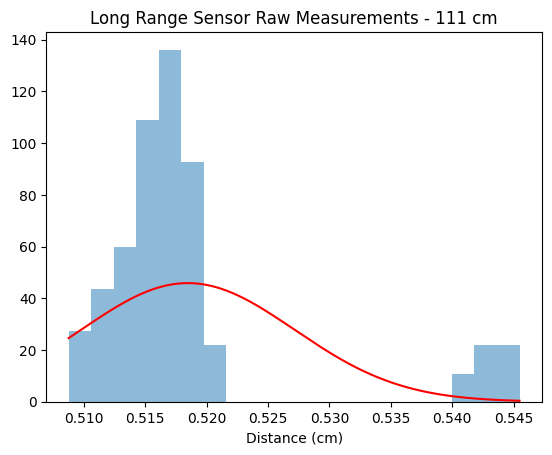

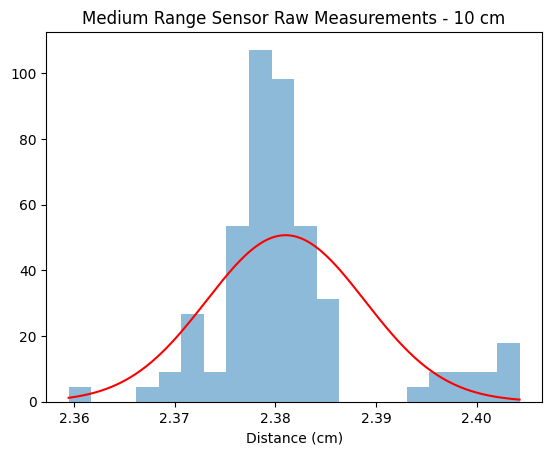

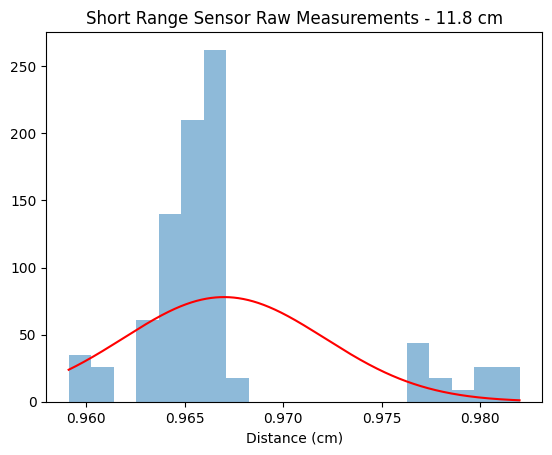

Variance and Standard Deviation Table
           Sensor Distance  Variance  Standard Deviation
       Long Range       20  0.000090            0.009494
       Long Range       33  0.000079            0.008895
       Long Range       46  0.000201            0.014181
       Long Range       59  0.000118            0.010885
       Long Range       72  0.000794            0.028176
       Long Range       85  0.000081            0.009008
       Long Range       98  0.000126            0.011243
       Long Range      111  0.000076            0.008695
       Long Range      124  0.000174            0.013193
       Long Range      137  0.000089            0.009456
       Long Range      150  0.000176            0.013276
  Long Range Avg.        0  0.431180            0.656643
     Medium Range       10  0.000062            0.007867
     Medium Range       17  0.000039            0.006236
     Medium Range       24  0.000051            0.007129
     Medium Range       31  0.000263            0.

In [7]:
# Create a data object to store the results
table_data = []
# Plot a histogram for the raw measurements at each distance from each sensor
for sensor in pa:
    for i, distance in enumerate(a_samples[sensor].keys()):
        mean = statistics.mean(a_samples[sensor][distance])
        std = statistics.stdev(a_samples[sensor][distance])
        variance = std**2
        table_data.append({
            "Sensor": sensor,
            "Distance": distance,
            "Variance": variance,
            "Standard Deviation": std,
        })
        x_axis = np.linspace(min(a_samples[sensor][distance]), max(a_samples[sensor][distance]), 1000)
        y_axis = norm.pdf(x_axis, mean, std)
        plt.figure()
        plt.hist(a_samples[sensor][distance], bins=20, density=True,alpha=0.5)
        plt.plot(x_axis, norm.pdf(x_axis, mean, std), label="Normal", color="red")
        plt.title(f"{sensor} Sensor Raw Measurements - {distance} cm")
        plt.xlabel("Distance (cm)")
        plt.ylabel("")
        pathlib.Path("out/plots").mkdir(parents=True, exist_ok=True)
        plt.savefig(f"out/plots/{sensor}_{distance}cm_raw_dist.png")
        if i == 0: # Only show the first plot
            plt.show()
        else:
            plt.close()
    # Create an std and variance for the sensor
    avg_var = statistics.mean([table_data[i]["Variance"] for i in range(len(table_data)) if table_data[i]["Sensor"] == sensor])
    avg_std = statistics.mean([table_data[i]["Standard Deviation"] for i in range(len(table_data)) if table_data[i]["Sensor"] == sensor])
    table_data.append({
        "Sensor": f"{sensor} Avg.",
        "Distance": "0",
        "Variance": avg_var,
        "Standard Deviation": avg_std,
    })

# Create a table of the variance and standard deviation
table_data.sort(key=lambda x: (x["Sensor"], float(x["Distance"].replace("cm", ""))))
table = pd.DataFrame(table_data)
print("Variance and Standard Deviation Table")
print(table.to_string(index=False))